In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymc as pm
# import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [3]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [4]:
param_grid = {
    "n_estimators": [0,10,50,100],
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = ExtraTreesRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2160 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/pyth

Param for GS {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
CV score for GS 0.7100489508853313
Train AUC ROC Score for GS:  0.9247177205875008
Test AUC ROC Score for GS:  0.7615795881636758


Text(0.5, 1.0, 'LUMO')

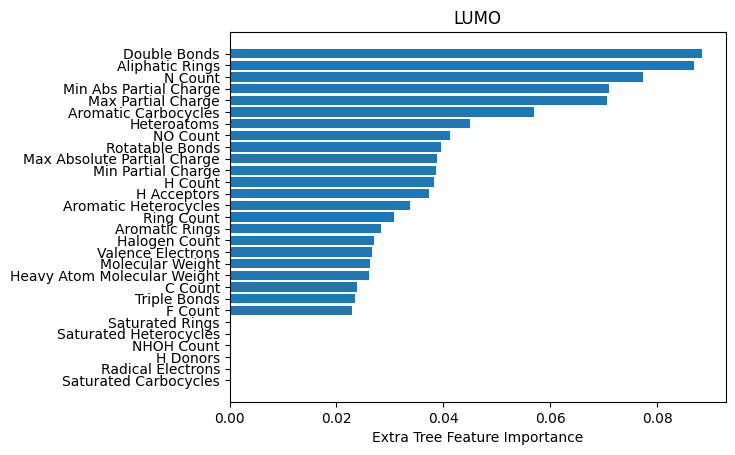

In [5]:
model = ExtraTreesRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
model.fit(X_train, y_train)

sorted_idx = model.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Extra Tree Feature Importance")
plt.title("LUMO")

In [6]:
r = permutation_importance(model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aliphatic Rings0.530 +/- 0.030
Double Bonds0.277 +/- 0.014
N Count 0.203 +/- 0.012
Max Partial Charge0.108 +/- 0.006
Aromatic Carbocycles0.103 +/- 0.008
Min Abs Partial Charge0.099 +/- 0.005
Halogen Count0.077 +/- 0.008
Heteroatoms0.071 +/- 0.004
NO Count0.061 +/- 0.004
F Count 0.055 +/- 0.007
Rotatable Bonds0.051 +/- 0.003
H Count 0.047 +/- 0.002
Aromatic Heterocycles0.045 +/- 0.004
Min Partial Charge0.044 +/- 0.002
H Acceptors0.041 +/- 0.003
Max Absolute Partial Charge0.039 +/- 0.002
Ring Count0.034 +/- 0.002
Molecular Weight0.033 +/- 0.002
Aromatic Rings0.031 +/- 0.002
Valence Electrons0.031 +/- 0.002
Heavy Atom Molecular Weight0.028 +/- 0.002
Triple Bonds0.026 +/- 0.003
C Count 0.026 +/- 0.001
Saturated Heterocycles0.000 +/- 0.000
Saturated Rings0.000 +/- 0.000
NHOH Count0.000 +/- 0.000


In [7]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = model.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

Mean Absolute Error: 0.16 degrees.
R2:  0.49881491083494744
MSE:  0.04850788039141443
RMSE:  0.2202450462358108


In [13]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge', 'Min Abs Partial Charge', 'NO Count',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [14]:
param_grid = {
    "n_estimators": [0,10,50,100],
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = ExtraTreesRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2160 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/pyth

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV score for GS 0.703255359646188
Train AUC ROC Score for GS:  0.9878797161722546
Test AUC ROC Score for GS:  0.7569742205282939


Text(0.5, 1.0, 'LUMO')

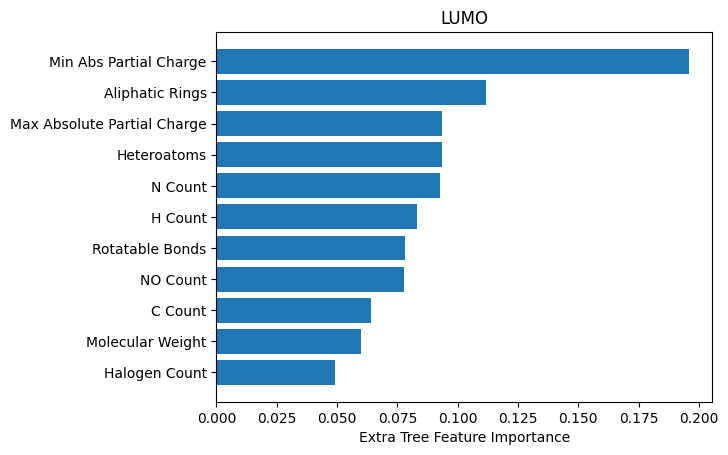

In [15]:
model = ExtraTreesRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
model.fit(X_train, y_train)

sorted_idx = model.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Extra Tree Feature Importance")
plt.title("LUMO")

In [16]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = model.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

Mean Absolute Error: 0.17 degrees.
R2:  0.4401875635912993
MSE:  0.05418220791879273
RMSE:  0.23277071963370463


In [17]:
r = permutation_importance(model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aliphatic Rings0.940 +/- 0.055
Min Abs Partial Charge0.475 +/- 0.022
N Count 0.232 +/- 0.011
Halogen Count0.213 +/- 0.019
NO Count0.183 +/- 0.011
Heteroatoms0.173 +/- 0.011
Max Absolute Partial Charge0.138 +/- 0.006
Rotatable Bonds0.125 +/- 0.006
H Count 0.110 +/- 0.005
Molecular Weight0.083 +/- 0.007
C Count 0.080 +/- 0.003
